<a href="https://colab.research.google.com/github/piaseckazaneta/CV/blob/master/Klasteryzacja_upraw_Sentinel2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Instalacja pakietów

In [1]:
!pip install geopandas rasterio matplotlib scikit-learn opencv-python
!pip install tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 76.4 MB/s eta 0:00:00


WCZYTAĆ KANAŁY I ZŁĄCZYĆ DO POSTACI JEDNEJ SCENY

In [22]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [27]:
import pandas as pd

/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


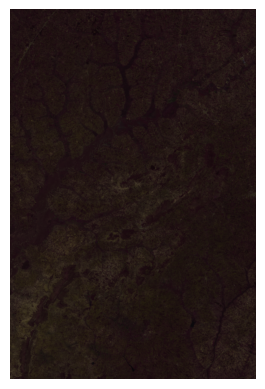

In [18]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import os

# Ścieżka do folderu z rasterami
folder_path = './rastry'

# Lista plików w folderze
files = os.listdir(folder_path)

# Przefiltruj tylko pliki .tif
raster_files = [f for f in files if f.endswith('.tif')]

# Posortuj pliki, aby upewnić się, że kanały będą w odpowiedniej kolejności
raster_files.sort()

# Wczytanie rastrów i zapisanie ich w odpowiednich kanałach
channels = []

for raster_file in raster_files:
    raster_path = os.path.join(folder_path, raster_file)

    # Wczytanie rastrowego obrazu
    with rasterio.open(raster_path) as src:
        data = src.read(1)  # Wczytanie danych z pierwszej warstwy (kanału)
        channels.append(data)

# Sprawdzenie, czy mamy 3 kanały (R, G, B)
assert len(channels) >= 3, "Za mało kanałów w folderze"

# Tworzenie obrazu RGB, wybierając odpowiednie kanały
r_channel = channels[4]  # Kanał R
g_channel = channels[3]  # Kanał G
b_channel = channels[2]  # Kanał B

# Łączenie kanałów w obraz RGB
rgb_image = np.stack([r_channel, g_channel, b_channel], axis=-1)

# Wyświetlenie obrazu RGB
plt.imshow(rgb_image)
plt.axis('off')  # Wyłączenie osi
plt.show()

!ls -R, aby wyświetlić strukturę katalogów w formie rekursywnej

„Rekursywnie” oznacza przeglądanie struktury katalogów w sposób zagnieżdżony, czyli nie tylko w obrębie bieżącego katalogu, ale również w katalogach, które znajdują się wewnątrz tego katalogu (i ich podkatalogach, i tak dalej).

W kontekście polecenia !ls -R, oznacza to, że system pokaże Ci nie tylko pliki znajdujące się w danym katalogu, ale również pliki w każdym jego podkatalogu, w każdym podkatalogu kolejnego katalogu, itd.

In [3]:
!ls -R

.:
rastry	sample_data

./rastry:
B01.tif  B03.tif  B05.tif  B07.tif  B09.tif  B12.tif
B02.tif  B04.tif  B06.tif  B08.tif  B11.tif  B8A.tif

./sample_data:
anscombe.json		     california_housing_train.csv  mnist_train_small.csv
california_housing_test.csv  mnist_test.csv		   README.md


In [11]:
# Załóżmy, że raster_stack to 3D tablica numpy (wysokość, szerokość, 12)
# np.min() i np.max() pozwolą sprawdzić zakres wartości w całej tablicy

min_value = np.min(raster_stack)
max_value = np.max(raster_stack)

print(f'Minimalna wartość: {min_value}')
print(f'Maksymalna wartość: {max_value}')

Minimalna wartość: 9.999999747378752e-05
Maksymalna wartość: 0.8842999935150146


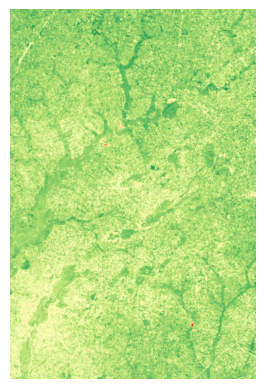

In [19]:
# Obliczenie NDVI
NDVI = (channels[8]-channels[4])/(channels[8]+channels[4])

# Wyświetlenie obrazu NDVI
plt.imshow(NDVI, cmap='RdYlGn')
plt.axis('off')
plt.show()

In [20]:
composite_data = np.stack([r_channel, g_channel, b_channel, NDVI], axis=-1)

Przygotowanie danych do klasteryzacji

Aby użyć algorytmu K-means, musisz spłaszczyć dane (każdy piksel w jednym wierszu) i znormalizować je, aby algorytm nie był wrażliwy na różnice w skali danych.

In [23]:
# Przekształcenie obrazu w wektor (spłaszczenie)
n_pixels = composite_data.shape[0] * composite_data.shape[1]
data_flattened = composite_data.reshape((n_pixels, composite_data.shape[2]))

# Normalizacja danych
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_flattened)

Klasyfikacja z K-means

Po przygotowaniu danych, przechodzimy do samego procesu klasteryzacji z użyciem K-means.

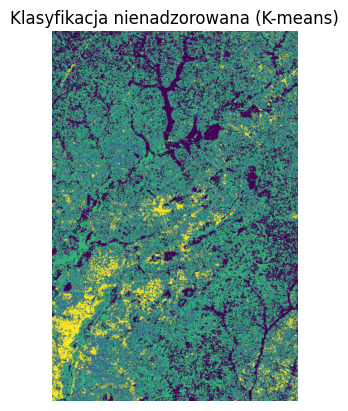

In [24]:
# Wykonanie klasteryzacji K-means
n_clusters = 4  # Liczba klas, zmień na odpowiednią liczbę
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(data_scaled)

# Przypisanie etykiet klastrów do każdego piksela
labels = kmeans.labels_

# Przekształcenie etykiet z powrotem do kształtu obrazu
labels_image = labels.reshape(composite_data.shape[0], composite_data.shape[1])

# Wizualizacja wyników klasteryzacji
plt.imshow(labels_image, cmap='viridis')  # Możesz wybrać inny kolor mapy
plt.title('Klasyfikacja nienadzorowana (K-means)')
plt.axis('off')
plt.show()

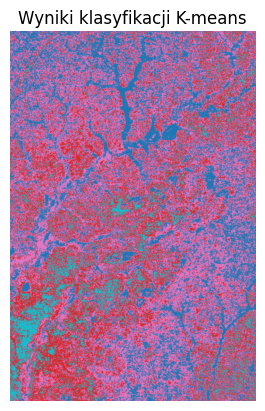

In [25]:
# Wizualizacja wyników klasteryzacji
plt.imshow(labels_image, cmap='tab10')  # Tablica z kolorami dla klas
plt.title('Wyniki klasyfikacji K-means')
plt.axis('off')
plt.show()

Klasteryzacja - kroki:

Przygotowanie danych – wczytanie odpowiednich kanałów (np. RGB, NIR, NDVI).

Zbudowanie kompozycji – wybór kanałów, które będą użyte do klasyfikacji.

Normalizacja danych – ważne, aby dane były w odpowiedniej skali.

Klasyfikacja nienadzorowana (K-means) – przypisanie pikseli do klastrów na podstawie wybranych cech.

Wizualizacja wyników – prezentacja wyników w postaci kolorowych klas.

In [28]:
field_train_test = pd.read_csv('field_train_test_ids.csv')

In [29]:
print(field_train_test.head())

   train    test
0   2590  4793.0
1   4704  2671.0
2   1338  1185.0
3   3228  1771.0
4   2951   500.0
